<a href="https://colab.research.google.com/github/geoburdin/-_-_-/blob/master/test_optimax_burdin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intuitively, it makes sense that the weather would affect the consumption of energy, e.g. heating or сooling. 
The first idea to check is whether there is a causation which we can statistically measure using Granger Causality.

# Data loading and cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df_energy = pd.read_csv('/content/drive/MyDrive/test_case/Consumption deviation 2017.csv', sep=';')
df_temp = pd.read_csv('/content/drive/MyDrive/test_case/asos.csv', sep=',')


In [ ]:
from datetime import datetime
df_energy = df_energy.drop(df_energy[df_energy.MW == '#WERT!'].index)
df_energy['timestamp (UTC)'] = pd.to_datetime(df_energy['timestamp (UTC)'])
df_energy["MW"] = df_energy['MW'].astype(str).astype(float)
df_temp['valid'] = pd.to_datetime(df_temp['valid'])
df_temp = df_temp.sort_values(by='valid')
df_energy = df_energy.sort_values(by='timestamp (UTC)')

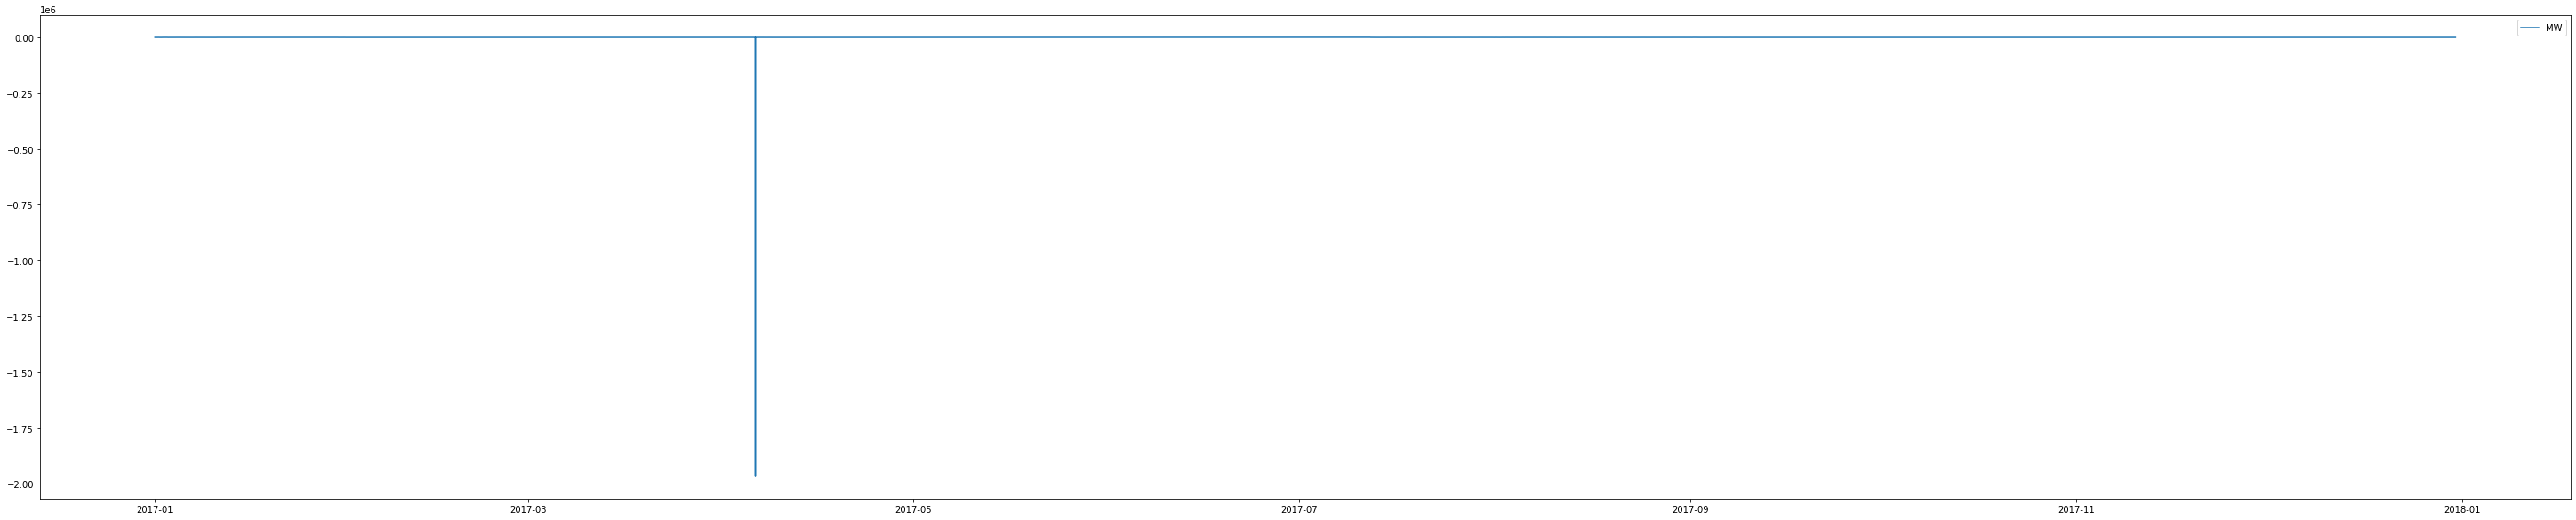

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import minmax_scale

frame = df_energy.sort_values(by='timestamp (UTC)')

plt.figure(figsize=(51, 10))

x = frame['timestamp (UTC)']
y1 = frame['MW']

plt.plot(x, y1, label = "MW")
plt.legend()
plt.show()

Remove outlier

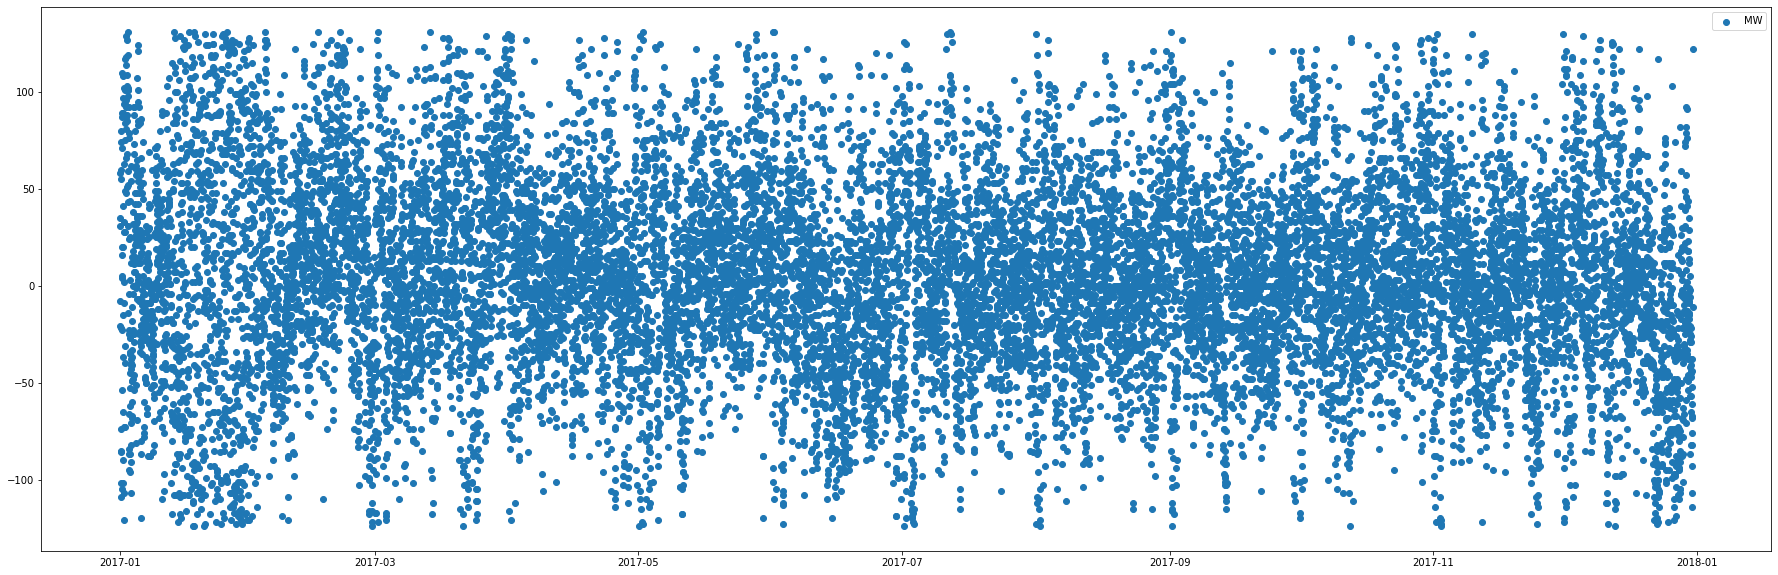

In [ ]:

q = df_energy["MW"].quantile(0.99)
q_low = df_energy["MW"].quantile(0.01)
df_energy = df_energy[(df_energy["MW"] < q )& (df_energy["MW"] > q_low)]

frame = df_energy.sort_values(by='timestamp (UTC)')
plt.figure(figsize=(31, 10))
x = frame['timestamp (UTC)']
y1 = frame['MW']
plt.scatter(x, y1, label = "MW")
plt.legend()
plt.show()

Zoom in to observe the trend

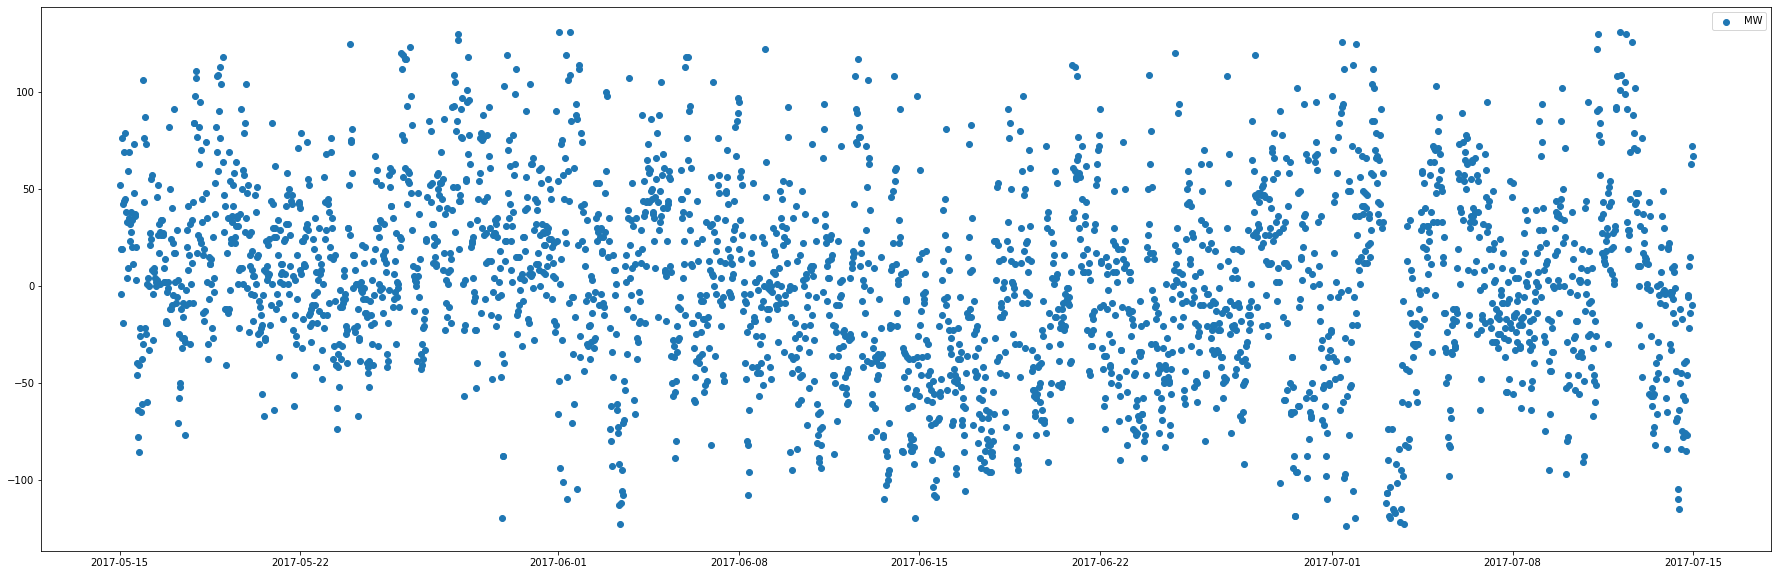

In [ ]:
frame = df_energy.loc[(df_energy['timestamp (UTC)']>'2017-05-15')&(df_energy['timestamp (UTC)']<'2017-07-15')]
plt.figure(figsize=(31, 10))
x = frame['timestamp (UTC)']
y1 = frame['MW']
plt.scatter(x, y1, label = "MW")
plt.legend()
plt.show()

It is also obvious that power producers will try to even out the imbalance by trying to build predictive models themselves. This certainly flattens the data a lot, preventing strong correlations from being detected

In [ ]:
#create new columns with the time information
def convert(df , column_timestamp):
    df['hour'] = df[column_timestamp].dt.hour 
    df['minute'] = df[column_timestamp].dt.minute 
    df['day'] = df[column_timestamp].dt.day 
    df['month'] = df[column_timestamp].dt.month
    df['dayofyear'] = df[column_timestamp].dt.dayofyear
convert(df_energy, 'timestamp (UTC)')
convert(df_temp, 'valid')


Let's divide the weather data into pre-2017, historical data, and 2017, notional real-time data, since we have grid disbalance data only for 2017

In [ ]:
df_temp_before = df_temp.loc[df_temp['valid'].dt.year <2017]
df_temp_rn = df_temp.loc[df_temp['valid'].dt.year == 2017]

### Add columns 

average_temp_in_past - average temperature among stations in France on a certain day of a certain month for past years

mean_temp_day - average temperature among French stations on a certain day of a certain month in 2017

std_temp_in_past - standard deviation of temperature among stations in France on a particular day of a particular month in the past years

tmpc - average temperature among French stations at a certain time on a certain day of a certain month in 2017

mean_mw_day - average imbalance in the grid on a certain day of a certain month in 2017

delta_temp = mean_temp_day - average_temp_in_past; Difference in the average daily temperature on a particular day compared to the average daily temperature in the past

In [ ]:
import datetime
df = df_energy.copy()
for index, row in df_energy.iterrows():
    stamp = row['timestamp (UTC)'] 

    frame = df_temp_before.loc[
        (df_temp_before['month'] == row['month'])&
        (df_temp_before['day'] == row['day'])]
    
        
    frame = frame.loc[
        (frame['hour'] == row['hour'])&
        (frame['minute'] == row['minute'])]

    mean_temp_before = frame['tmpc'].mean()
    std_temp_before = frame['tmpc'].std()

    mean_temp_rn = df_temp_rn.loc[df_temp_rn['valid']==stamp]['tmpc'].mean()
    mean_temp_day = df_temp_rn.loc[
        (df_temp_rn['month'] == row['month'])&
        (df_temp_rn['day'] == row['day'])]['tmpc'].mean()
    mean_mw_day_before = df_energy.loc[
        (df_energy['month'] == row['month'])&
        (df_energy['day'] == row['day'])]['MW'].mean()

    df.at[index, "average_temp_in_past"] = mean_temp_before
    df.at[index, "mean_temp_day"] = mean_temp_day
    df.at[index, "std_temp_in_past"] = std_temp_before
    df.at[index, "tmpc"] = mean_temp_rn
    df.at[index+1, "mean_mw_day_before"] = mean_mw_day_before
    if index == 0:
        df.at[0, "mean_mw_day_before"] = mean_mw_day_before

In [ ]:
df['timestamp (UTC)'] = pd.to_datetime(df_energy['timestamp (UTC)'])
df["mean_mw_day_before"].fillna( method ='ffill', inplace = True)

df['delta_temp'] = df['mean_temp_day'] - df['average_temp_in_past']


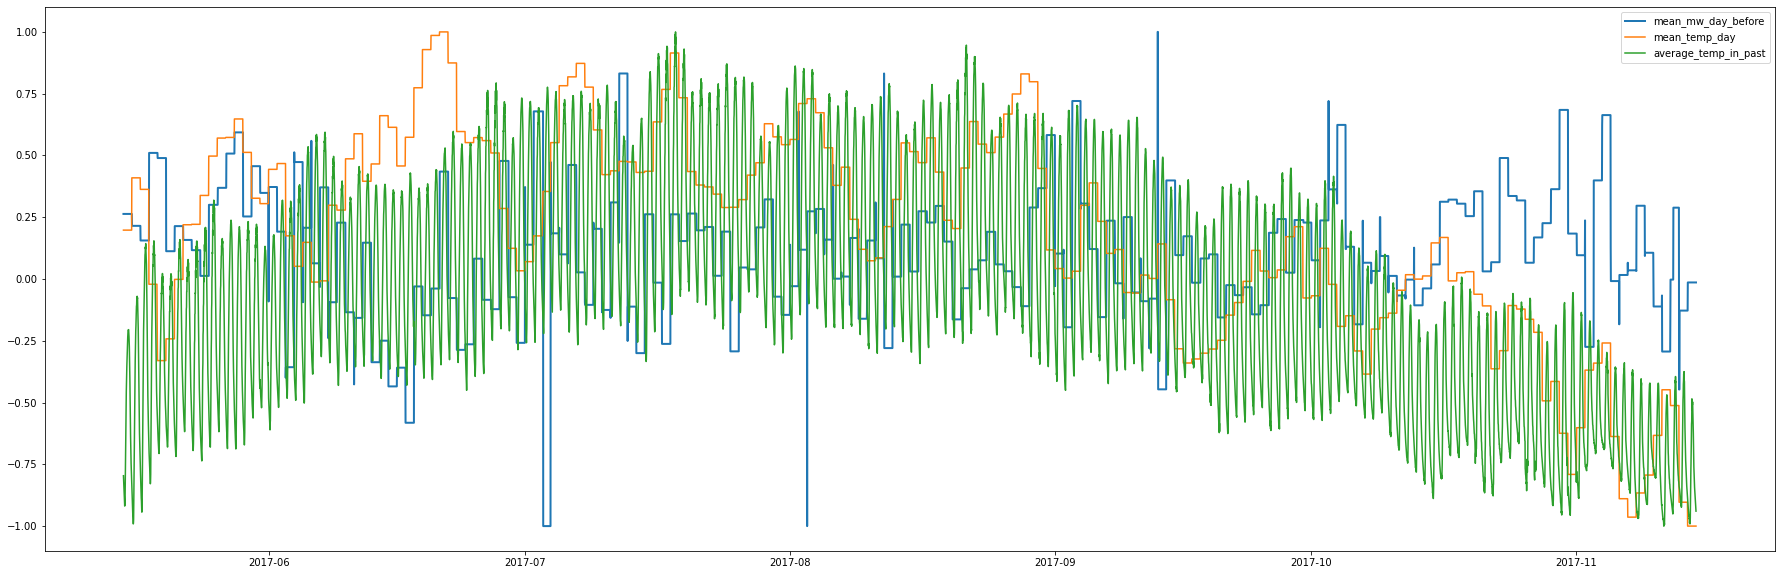

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import minmax_scale

frame = df.loc[(df['timestamp (UTC)'] >'2017-05-15')&(df['timestamp (UTC)']<'2017-11-15')].sort_values(by='timestamp (UTC)')

plt.figure(figsize=(31, 10))

x = frame['timestamp (UTC)']

y2 =  minmax_scale(frame['mean_temp_day'], feature_range = (-1,1))
y3 =  minmax_scale(frame['mean_mw_day_before'], feature_range = (-1,1))
y4 =  minmax_scale(frame['average_temp_in_past'], feature_range = (-1,1))
  
plt.plot(x, y3, label = "mean_mw_day_before", linewidth=2.0)

plt.plot(x, y2, label = "mean_temp_day")

plt.plot(x, y4, label = "average_temp_in_past")
plt.legend()
plt.show()

#     The Granger Causality Test


> Granger Causality is a hypothesis test that measures if one time series has a statistically significant effect on another.


The null hypothesis for each test is that lagged values of the temperature data do not statistically explain the trends of the energy surplus/deficit data. In other words, we assume that :
###     **The temperature in presence explains the change in the equilibrium of the power grid **
Let's build our hypothesis test around that assumption.

In [ ]:
df.describe()

,MW,hour,minute,day,month,dayofyear,average_temp_in_past,mean_temp_day,std_temp_in_past,tmpc,mean_mw_day_before,delta_temp
count,17080.000000,17080.000000,17080.000000,17080.000000,17080.000000,17080.000000,17080.000000,17080.000000,17080.000000,17075.000000,17321.000000,17080.000000
mean,4.662529,11.486944,15.024590,15.724883,6.522014,182.879567,12.688910,12.964275,3.963648,12.932344,4.664871,0.275366
std,48.702695,6.908099,15.000419,8.765836,3.425106,104.619189,6.124241,6.368057,0.628828,7.009577,21.406558,3.893484
min,-124.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.657492,-1.511837,2.364524,-5.030612,-83.300000,-9.739663
25%,-27.000000,5.000000,0.000000,8.000000,4.000000,93.000000,7.445553,8.006299,3.504310,7.543016,-8.000000,-2.552544
50%,4.000000,11.000000,30.000000,16.000000,7.000000,183.000000,12.378776,12.489667,3.900784,12.683168,4.604167,0.222778
75%,36.000000,17.000000,30.000000,23.000000,9.000000,273.000000,17.170091,18.088832,4.393532,18.020836,18.062500,3.123361
max,131.000000,23.000000,30.000000,31.000000,12.000000,365.000000,27.578397,26.089057,6.143404,32.225490,73.868421,12.438575


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
df["MW"].fillna( method ='ffill', inplace = True)
df["tmpc"].fillna( method ='ffill', inplace = True)
df_to_causality=df[{'MW', 'tmpc'}]
grangercausalitytests(df_to_causality, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2088  , p=0.0073  , df_denom=17317, df_num=1
ssr based chi2 test:   chi2=7.2101  , p=0.0072  , df=1
likelihood ratio test: chi2=7.2086  , p=0.0073  , df=1
parameter F test:         F=7.2088  , p=0.0073  , df_denom=17317, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0545  , p=0.0472  , df_denom=17314, df_num=2
ssr based chi2 test:   chi2=6.1107  , p=0.0471  , df=2
likelihood ratio test: chi2=6.1097  , p=0.0471  , df=2
parameter F test:         F=3.0545  , p=0.0472  , df_denom=17314, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2356  , p=0.0053  , df_denom=17311, df_num=3
ssr based chi2 test:   chi2=12.7119 , p=0.0053  , df=3
likelihood ratio test: chi2=12.7073 , p=0.0053  , df=3
parameter F test:         F=4.2356  , p=0.0053  , df_denom=17311, df_num=3


{1: ({'ssr_ftest': (7.208806744063831, 0.007261578825538995, 17317.0, 1),
   'ssr_chi2test': (7.210055598959725, 0.007249624858390364, 1),
   'lrtest': (7.208555296438135, 0.007255687493333283, 1),
   'params_ftest': (7.2088067440662815, 0.007261578825524077, 17317.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.0544842803262497, 0.04717243581113124, 17314.0, 2),
   'ssr_chi2test': (6.1107327308502155, 0.04710545979680567, 2),
   'lrtest': (6.109654947103991, 0.0471308513873158, 2),
   'params_ftest': (3.0544842803101573, 0.047172435811878126, 17314.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.235603827938901, 0.005326154632988352, 17311.0, 3),
   'ssr_chi2test': (12.711949701157508, 0.0053028076631777155, 3),
   'lrtest': (12.707286500095506, 0.0053143369391733765, 3),
   'params_ftest': (4.23560382795207, 0.0053261546329036085, 17311.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 

And from the first lag we see that the p-value goes to 0, which clearly proves the causal connection. that is, 
### The average temperature in France affects the value of the imbalance in the grid

Now I will try to find how exactly temperature will affect the imbalance. Let's look at the correlation matrix

In [ ]:
df.corr()

,MW,hour,minute,day,month,dayofyear,average_temp_in_past,mean_temp_day,std_temp_in_past,tmpc,mean_mw_day_before,delta_temp
MW,1.000000,0.006451,0.025846,-0.000172,-0.073765,-0.073537,-0.092678,-0.023766,-0.070249,-0.072353,0.428270,0.106907
hour,0.006451,1.000000,0.005216,-0.002008,0.000008,-0.000138,0.178565,-0.000959,0.038011,0.163047,-0.003201,-0.282441
minute,0.025846,0.005216,1.000000,-0.001198,-0.000728,-0.000829,0.000803,-0.000533,-0.016220,-0.001396,0.003151,-0.002135
day,-0.000172,-0.002008,-0.001198,1.000000,0.005392,0.088955,0.010389,0.062538,-0.004252,0.056898,-0.001031,0.085944
month,-0.073765,0.000008,-0.000728,0.005392,1.000000,0.996479,0.254046,0.181022,0.012024,0.164296,-0.170188,-0.103528
dayofyear,-0.073537,-0.000138,-0.000829,0.088955,0.996479,1.000000,0.251081,0.182211,0.013332,0.165382,-0.169720,-0.096919
average_temp_in_past,-0.092678,0.178565,0.000803,0.010389,0.254046,0.251081,1.000000,0.806411,-0.033126,0.897363,-0.087225,-0.254007
mean_temp_day,-0.023766,-0.000959,-0.000533,0.062538,0.181022,0.182211,0.806411,1.000000,-0.209586,0.907642,-0.054036,0.367127
std_temp_in_past,-0.070249,0.038011,-0.016220,-0.004252,0.012024,0.013332,-0.033126,-0.209586,1.000000,-0.027183,-0.022660,-0.290688
tmpc,-0.072353,0.163047,-0.001396,0.056898,0.164296,0.165382,0.897363,0.907642,-0.027183,1.000000,-0.047319,0.073006


The imbalance is most correlated with the average imbalance of the previous day, which is very logical, the most elementary forecast for tomorrow is the values for yesterday

The maximum correlation of imbalance is with the difference between the average temperature in the past and the temperature at the moment. Nevertheless, a value of 0.098755 means a very bad correlation

I assume that it is impossible to build a predictive model based on temperature data alone. However, it can increase the accuracy of the predictions

I propose to compare the predictions of different methods with and without temperature data

# XGboost
XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models

In [ ]:
#Split the dataset into training and for validation by date 2017-10-01
df_train = df.loc[(df['timestamp (UTC)'] < '2017-10-01')].copy()
df_test = df.loc[df['timestamp (UTC)'] > '2017-10-01 00:00:00'].copy()

#Convert the variables into the features that we take into the model
def create_features(df, label):
    X = df[['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'month', 'dayofyear', 'mean_mw_day_before', 'delta_temp']]
    y = df[label]
    return X, y
  
X_train, y_train = create_features(df_train, label='MW')
X_test, y_test = create_features(df_test, label='MW')

In [ ]:
from xgboost.callback import early_stop
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 

[15:19:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:38.2812	validation_1-mae:36.3435
[1]	validation_0-mae:37.6183	validation_1-mae:35.7308
[2]	validation_0-mae:37.0739	validation_1-mae:35.3544
[3]	validation_0-mae:36.6105	validation_1-mae:34.9256
[4]	validation_0-mae:36.2401	validation_1-mae:34.5569
[5]	validation_0-mae:35.9019	validation_1-mae:34.2321
[6]	validation_0-mae:35.6268	validation_1-mae:34.0158
[7]	validation_0-mae:35.3848	validation_1-mae:33.8388
[8]	validation_0-mae:35.1801	validation_1-mae:33.672
[9]	validation_0-mae:35.0119	validation_1-mae:33.4836
[10]	validation_0-mae:34.8637	validation_1-mae:33.3376
[11]	validation_0-mae:34.7303	validation_1-mae:33.2429
[12]	validation_0-mae:34.6217	validation_1-mae:33.1489
[13]	validation_0-mae:34.5213	validation_1-mae:33.0692
[14]	validation_0-mae:34.4251	validation_1-mae:32.9885
[15]	validation_0-mae:34.3503	validation_1-mae:32.9227
[16]

XGBRegressor()

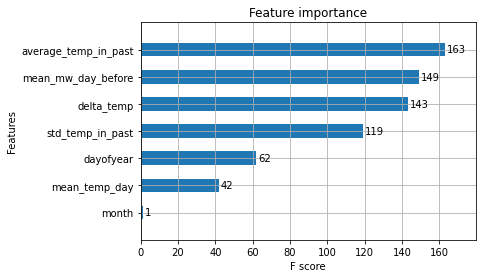

In [ ]:
_ = plot_importance(reg, height=0.5) 

In [ ]:
df_test['MW_Prediction'] = reg.predict(X_test)

Repeat for the same period but without temperature data

In [ ]:
def create_features(df, label=None):
    X = df[[ 'month', 'dayofyear', 'mean_mw_day_before']]
    if label:
        y = df[label]
        return X, y
    return X
X_train, y_train = create_features(df_train, label='MW')
X_test, y_test = create_features(df_test, label='MW')

reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 
df_test['MW_Prediction_simple'] = reg.predict(X_test)

[15:19:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:38.298	validation_1-mae:36.2881
[1]	validation_0-mae:37.6862	validation_1-mae:35.6558
[2]	validation_0-mae:37.1793	validation_1-mae:35.1106
[3]	validation_0-mae:36.757	validation_1-mae:34.7056
[4]	validation_0-mae:36.4033	validation_1-mae:34.3651
[5]	validation_0-mae:36.1084	validation_1-mae:34.0597
[6]	validation_0-mae:35.8627	validation_1-mae:33.7991
[7]	validation_0-mae:35.658	validation_1-mae:33.6024
[8]	validation_0-mae:35.49	validation_1-mae:33.4086
[9]	validation_0-mae:35.3465	validation_1-mae:33.2757
[10]	validation_0-mae:35.2275	validation_1-mae:33.1624
[11]	validation_0-mae:35.1303	validation_1-mae:33.0463
[12]	validation_0-mae:35.0517	validation_1-mae:32.9725
[13]	validation_0-mae:34.9879	validation_1-mae:32.9129
[14]	validation_0-mae:34.9331	validation_1-mae:32.8557
[15]	validation_0-mae:34.8879	validation_1-mae:32.8012
[16]	val

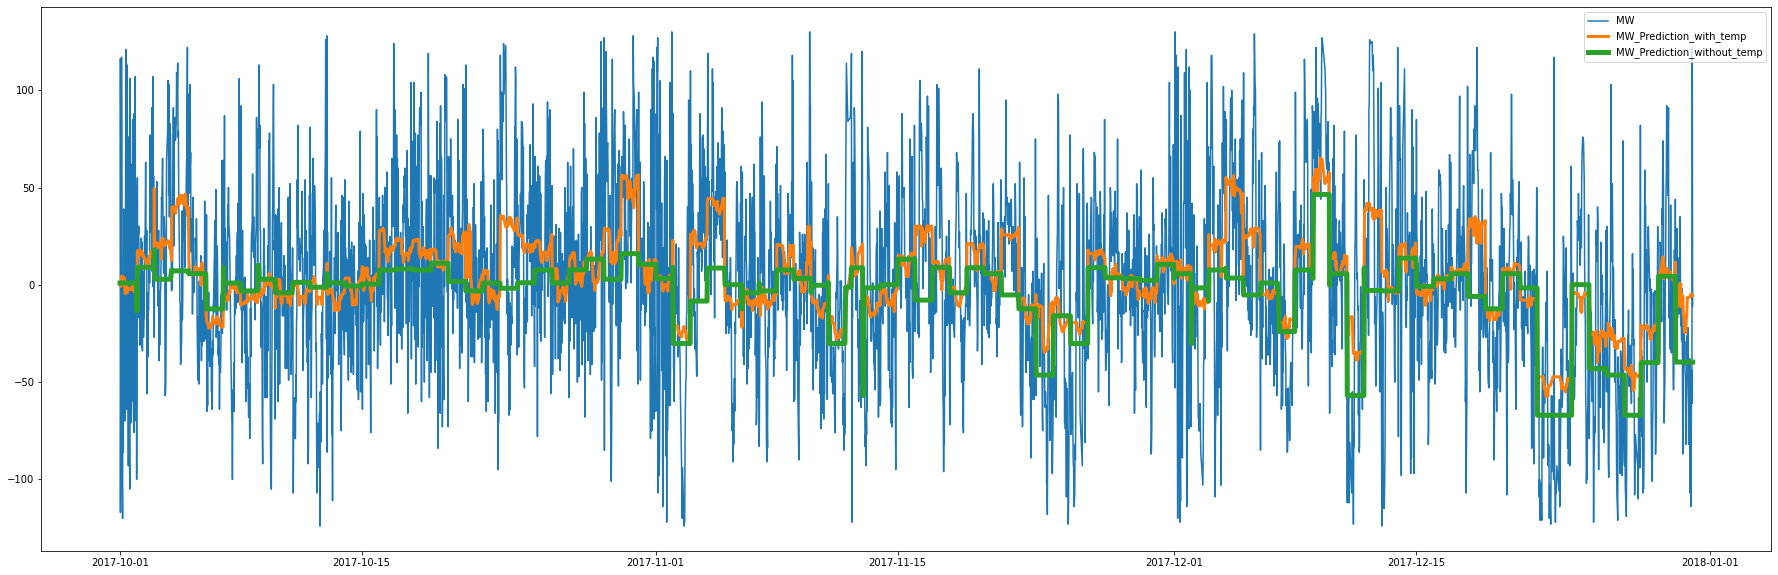

In [ ]:

plt.figure(figsize=(31, 10))

x = df_test['timestamp (UTC)']
y1 = df_test['MW_Prediction']
y2 =  df_test['MW']
y3 =  df_test['MW_Prediction_simple']
  
plt.plot(x, y2, label = "MW")
plt.plot(x, y1, label = "MW_Prediction_with_temp",linewidth=3.0)
plt.plot(x, y3, label = "MW_Prediction_without_temp",linewidth=5.0)
plt.legend()
plt.show()

In [ ]:
df_test.corr()

,MW,hour,minute,day,month,dayofyear,average_temp_in_past,mean_temp_day,std_temp_in_past,tmpc,mean_mw_day_before,delta_temp,MW_Prediction,MW_Prediction_simple
MW,1.000000,0.002604,0.034788,-0.083986,-0.126540,-0.148471,0.062211,0.039510,-0.040787,0.003921,0.473277,-0.020626,0.457013,0.382055
hour,0.002604,1.000000,0.004551,-0.001176,0.001444,0.001030,0.176548,-0.000927,-0.207210,0.145854,0.002447,-0.215414,-0.038754,0.001075
minute,0.034788,0.004551,1.000000,-0.003206,0.001162,0.000022,0.005015,-0.000851,-0.021815,-0.002022,0.007080,-0.007263,0.004498,0.004038
day,-0.083986,-0.001176,-0.003206,1.000000,-0.024265,0.310823,-0.222149,-0.078910,0.254764,-0.067576,-0.175201,0.159934,-0.132987,-0.186733
month,-0.126540,0.001444,0.001162,-0.024265,1.000000,0.942603,-0.757927,-0.812229,0.300417,-0.716906,-0.266722,-0.207840,-0.206842,-0.340222
dayofyear,-0.148471,0.001030,0.000022,0.310823,0.942603,1.000000,-0.795322,-0.800491,0.369537,-0.705873,-0.312363,-0.146198,-0.241560,-0.385595
average_temp_in_past,0.062211,0.176548,0.005015,-0.222149,-0.757927,-0.795322,1.000000,0.711994,-0.432185,0.840274,0.182393,-0.224850,0.062897,0.207110
mean_temp_day,0.039510,-0.000927,-0.000851,-0.078910,-0.812229,-0.800491,0.711994,1.000000,-0.289552,0.882594,0.086403,0.524112,0.068979,0.073206
std_temp_in_past,-0.040787,-0.207210,-0.021815,0.254764,0.300417,0.369537,-0.432185,-0.289552,1.000000,-0.265136,-0.071224,0.122378,-0.021030,-0.083443
tmpc,0.003921,0.145854,-0.002022,-0.067576,-0.716906,-0.705873,0.840274,0.882594,-0.265136,1.000000,0.076754,0.205609,0.022250,0.063173


In [ ]:
loss_tensor_with_temp = (df_test['MW_Prediction'] - df_test["MW"]) ** 2
loss_tensor_without_temp = (df_test['MW_Prediction_simple'] - df_test["MW"]) ** 2
print('Mean squared loss for XGBoost with temperature data:{} \nMean squared loss for XGBoost without temperature data:{}'.format(loss_tensor_with_temp.mean(), loss_tensor_without_temp.mean()))

Mean squared loss for XGBoost with temperature data:1778.156154118886 
Mean squared loss for XGBoost without temperature data:1951.6411119418372


# Prophet
Prophet is an additive regression model with a piecewise linear or logistic growth curve trend. Prophet is open source software released by Facebook’s Core Data Science team.

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Split the dataset into training and for validation by date 2017-10-01

In [ ]:
df_train = df.loc[df['timestamp (UTC)'] <= '2017-10-01 00:00:00'].copy().sort_values(by='timestamp (UTC)')
df_test = df.loc[df['timestamp (UTC)'] > '2017-10-01 00:00:00'].copy().sort_values(by='timestamp (UTC)')
df_full = df.loc[df['timestamp (UTC)'] < '2018-01-01 00:00:00'].copy().sort_values(by='timestamp (UTC)')[df['timestamp (UTC)'].notnull()]
X_train = df_train[['hour',	'minute',	'day',	'month',	'dayofyear','average_temp_in_past','std_temp_in_past','tmpc' ,"mean_mw_day_before", 'delta_temp']]
y_train = df_train['MW']
X_test = df_test[['hour',	'minute',	'day',	'month',	'dayofyear','average_temp_in_past','std_temp_in_past','tmpc', "mean_mw_day_before", 'delta_temp']]
y_test = df_test['MW']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from fbprophet import Prophet

df_frame = df_train.rename({'MW':'y'}, axis=1).copy().sort_values(by='timestamp (UTC)')

df_frame['ds']=df_frame['timestamp (UTC)']

m = Prophet()

m.add_regressor('dayofyear')
m.add_regressor('month')
m.add_regressor('day')
m.add_regressor('minute')
m.add_regressor('hour')

m.add_regressor('delta_temp')
m.add_regressor('average_temp_in_past')
m.add_regressor('std_temp_in_past')
m.add_regressor('mean_mw_day_before')
m.add_regressor('mean_temp_day')
m.add_regressor('tmpc')

m.fit(df_frame)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
df_full = df_full.rename({'MW':'y'}, axis=1)
df_full['ds']=df_full['timestamp (UTC)']
forecast = m.predict(df_full.drop(columns="y"))

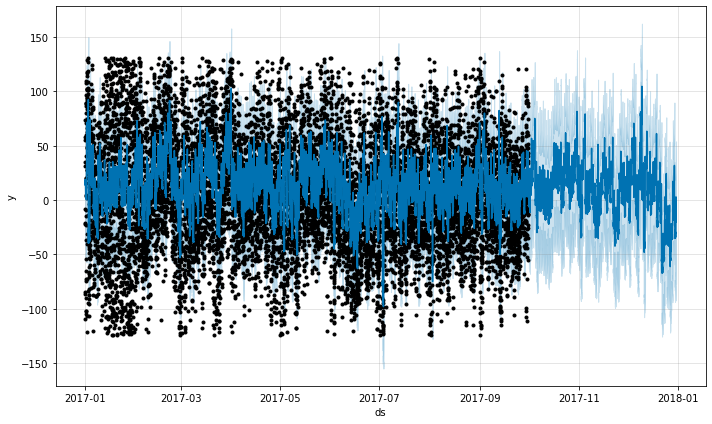

In [ ]:
m.plot(forecast);

In [ ]:
m = Prophet()

m.add_regressor('dayofyear')
m.add_regressor('month')
m.add_regressor('day')
m.add_regressor('minute')
m.add_regressor('hour')
m.add_regressor('mean_mw_day_before')

df_frame = df_train.rename({'MW':'y'}, axis=1).copy().sort_values(by='timestamp (UTC)')
df_frame=df_frame[pd.to_numeric(df_frame['y'], errors='coerce').notnull()]
df_frame['ds']=df_frame['timestamp (UTC)']

df_frame=df_frame[pd.to_numeric(df_frame['average_temp_in_past'], errors='coerce').notnull()]
df_frame=df_frame[pd.to_numeric(df_frame['std_temp_in_past'], errors='coerce').notnull()]

m.fit(df_frame)

forecast_simple = m.predict(df_full.drop(columns="y"))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


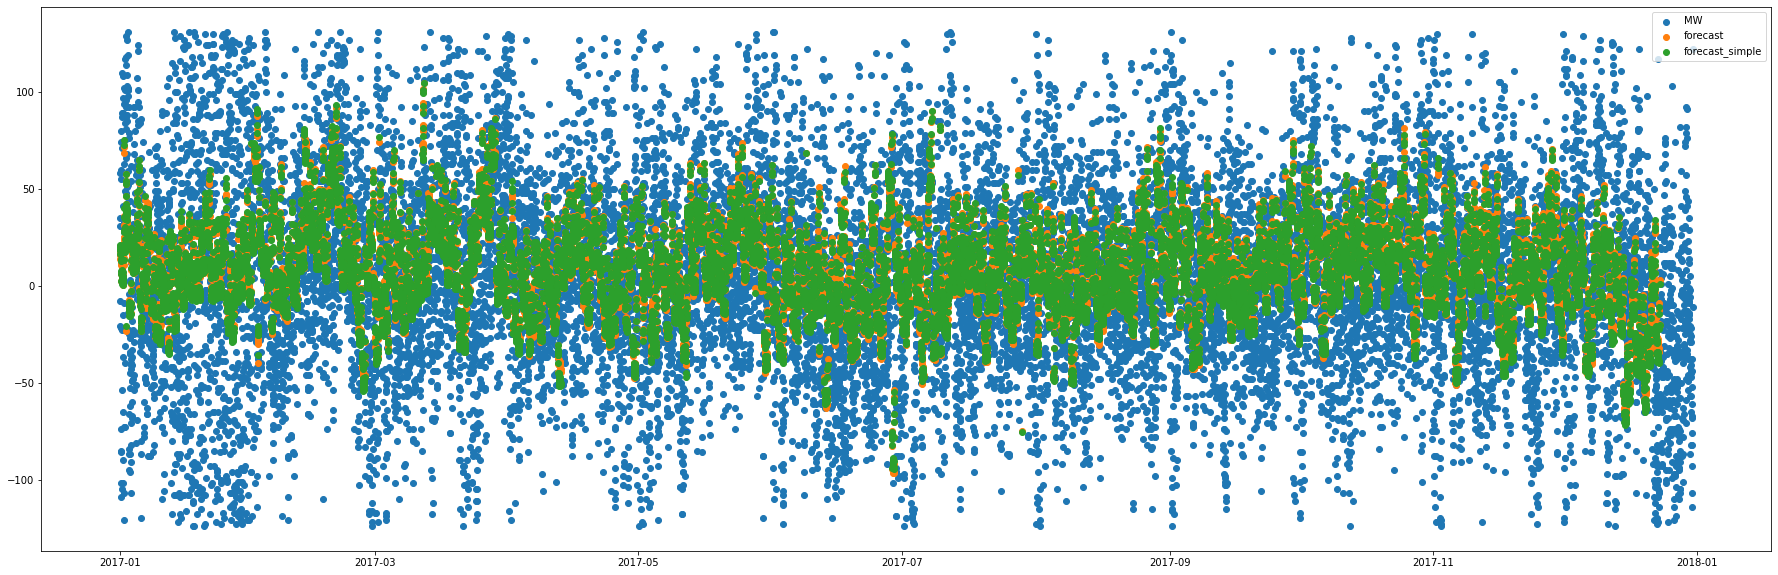

In [ ]:

df_full['MW_Prediction'] = forecast['yhat']
df_full['MW_Prediction_simple'] = forecast_simple['yhat']
plt.figure(figsize=(31, 10))

x = df_full['ds']
y1 = df_full['y']
y2 =  df_full['MW_Prediction']
y3 =  df_full['MW_Prediction_simple']
  

plt.scatter(x, y1, label = "MW")
plt.scatter(x, y2, label = "forecast")
plt.scatter(x, y3, label = "forecast_simple")
plt.legend()
plt.show()

Plot after 01.01.2017 is a prediction for the test dataset

In [ ]:
correlations = df_full.corr(method='pearson')
print(correlations['y'].sort_values(ascending=False).to_string())

y                       1.000000
mean_mw_day_before      0.434833
delta_temp              0.106907
MW_Prediction           0.060007
MW_Prediction_simple    0.057701
minute                  0.025846
hour                    0.006451
day                    -0.000172
mean_temp_day          -0.023766
std_temp_in_past       -0.070249
dayofyear              -0.073537
tmpc                   -0.073732
month                  -0.073765
average_temp_in_past   -0.092678


In [ ]:
loss_tensor_with_temp = (df_full['MW_Prediction'] - df_full["y"]) ** 2
loss_tensor_without_temp = (df_full['MW_Prediction_simple'] - df_full["y"]) ** 2
print('Mean squared loss for Prophet with temperature data:{} \nMean squared loss for Prophet without temperature data:{}'.format(loss_tensor_with_temp.mean(), loss_tensor_without_temp.mean()))

Mean squared loss for Prophet with temperature data:2761.0375493865863 
Mean squared loss for Prophet without temperature data:2772.968039484543


Error with temperature data is slightly, but decreasing

# LSTM
Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

cols = list(df)[1:15]
 
print(cols) 

['MW', 'hour', 'minute', 'day', 'month', 'dayofyear', 'average_temp_in_past', 'mean_temp_day', 'std_temp_in_past', 'tmpc', 'mean_mw_day_before', 'delta_temp']


In [ ]:
df_for_training = df.loc[df['timestamp (UTC)'] <= '2017-10-01 00:00:00'][cols].astype(float)

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []

n_future = 1  
n_past = 250  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (12576, 250, 11).
trainY shape == (12576, 1).


In [ ]:
import keras
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mse')
model.summary()
history = model.fit(trainX, trainY, epochs=3, batch_size=256, validation_split=0.2, verbose=1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 512)               1073152   
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,073,665
Trainable params: 1,073,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 450s 11s/step - loss: 0.9279 - val_loss: 0.6128
Epoch 2/3
40/40 [==============================] - 453s 11s/step - loss: 0.8438 - val_loss: 0.6281
Epoch 3/3
40/40 [==============================] - 446s 11s/step - loss: 0.8323 - val_loss: 0.6295


In [ ]:

n_past = 250
n_for_prediction=4301
train_dates = df['timestamp (UTC)']

prediction = model.predict(trainX[-n_for_prediction:]) 


prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)




135/135 [==============================] - 78s 579ms/step


Repeat without temperature data

In [ ]:
df_for_training = df.loc[df['timestamp (UTC)'] <= '2017-10-01 00:00:00'][['MW', 'hour', 'minute', 'day', 'month', 'dayofyear', 'mean_mw_day_before']].astype(float)

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
trainX = []
trainY = []

n_future = 1  
n_past = 250  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mse')
model.summary()
history = model.fit(trainX, trainY, epochs=3, batch_size=256, validation_split=0.2, verbose=1)

trainX shape == (12576, 250, 6).
trainY shape == (12576, 1).
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 512)               1062912   
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,063,425
Trainable params: 1,063,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 447s 11s/step - loss: 0.9206 - val_loss: 0.6187
Epoch 2/3
40/40 [==============================] - 440s 11s/step - loss: 0.8554 - val_loss: 0.6108
Epoch 3/3
40/40 [==============================] - 443s 11s/step - loss: 0.8407 - val_loss: 0.6243


In [ ]:
n_past = 250
n_for_prediction=4301
train_dates = df['timestamp (UTC)']

prediction = model.predict(trainX[-n_for_prediction:]) 


prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future_simple = scaler.inverse_transform(prediction_copies)


135/135 [==============================] - 77s 568ms/step


In [ ]:
df_forecast = pd.DataFrame({'Date':df[(df['timestamp (UTC)']>'2017-09-30' )&(df['timestamp (UTC)']<'2018-01-01' ) ]['timestamp (UTC)'], 'MW_pred_with_temp':y_pred_future[:,0], 'MW_pred_without_temp':y_pred_future_simple[:,0]})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

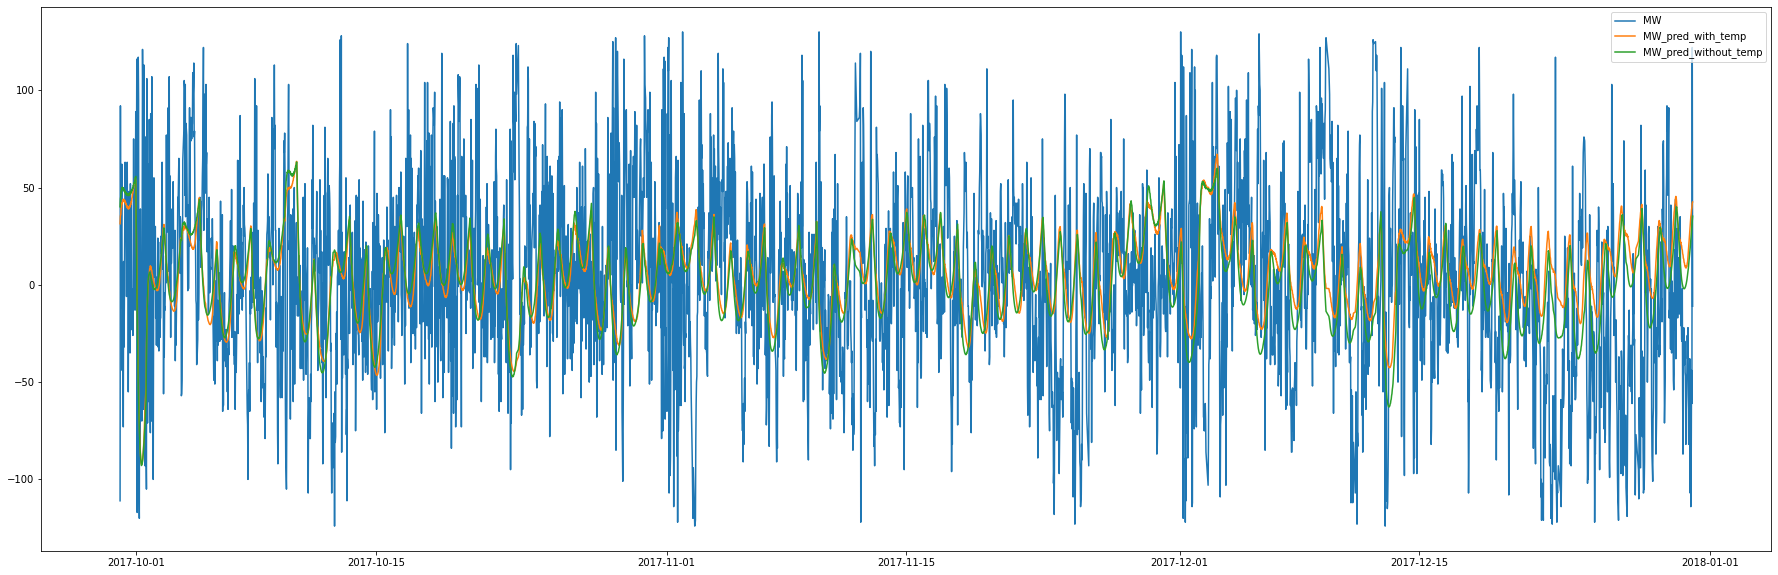

In [ ]:
plt.figure(figsize=(31, 10))

x = df[(df['timestamp (UTC)']>'2017-09-30' )&(df['timestamp (UTC)']<'2018-01-01' ) ]['timestamp (UTC)']
y1 = df[(df['timestamp (UTC)']>'2017-09-30' )&(df['timestamp (UTC)']<'2018-01-01' ) ]['MW']
y2 =  df_forecast['MW_pred_with_temp']
y3 =  df_forecast['MW_pred_without_temp']

plt.plot(x, y1, label = "MW")
plt.plot(x, y2, label = "MW_pred_with_temp")
plt.plot(x, y3, label = "MW_pred_without_temp")
plt.legend()
plt.show()


In [ ]:
loss_tensor_with_temp = (df_forecast['MW_pred_with_temp'] - y1) ** 2
loss_tensor_without_temp = (df_forecast['MW_pred_without_temp'] - y1) ** 2
print('Mean squared loss for LSTM with temperature data:{} \nMean squared loss for LSTM without temperature data:{}'.format(loss_tensor_with_temp.mean(), loss_tensor_without_temp.mean()))

Mean squared loss for LSTM with temperature data:2625.125104251127 
Mean squared loss for LSTM without temperature data:2667.768545407885


As a result, for all three models, the error when using temperature data becomes smaller.  Knowledge of temperature is certainly useful

Next I am confused because XGBoost showed the best results, but for the lstm-based model a much more complex architecture can be chosen, while for XGBoost I see only the possibility of tune parameters and targeting on quartiles of the distribution to get a probabilistic forecast

# Xgboost quantile prediction

In [ ]:
df_dayly = pd.DataFrame(columns=['Date', 'mean_mw', 'mw_05', 'mw_95', 'median_mw', 'average_temp_in_past', 'std_temp_in_past', 'mean_temp_day'])

for index, row in df_energy.iterrows():
    
    frame = df_temp_before.loc[
        (df_temp_before['month'] == row['month'])&
        (df_temp_before['day'] == row['day'])]

    mean_temp_before = frame['tmpc'].mean()
    std_temp_before = frame['tmpc'].std()
    mean_temp_day = df_temp_rn.loc[
        (df_temp_rn['month'] == row['month'])&
        (df_temp_rn['day'] == row['day'])]['tmpc'].mean()
    
    mean_mw = df_energy.loc[
        (df_energy['month'] == row['month'])&
        (df_energy['day'] == row['day'])]['MW'].mean()
    median_mw = df_energy.loc[
        (df_energy['month'] == row['month'])&
        (df_energy['day'] == row['day'])]['MW'].median()
    mw_95 = df_energy.loc[
        (df_energy['month'] == row['month'])&
        (df_energy['day'] == row['day'])]['MW'].quantile(0.05)
    mw_05 = df_energy.loc[
        (df_energy['month'] == row['month'])&
        (df_energy['day'] == row['day'])]['MW'].quantile(0.95)
    df_dayly.at[row['dayofyear'], "Date"] = row['timestamp (UTC)'].date()
    df_dayly.at[row['dayofyear'], "average_temp_in_past"] = mean_temp_day
    df_dayly.at[row['dayofyear'], "mean_temp_day"] = mean_temp_day
    df_dayly.at[row['dayofyear'], "std_temp_in_past"] = std_temp_before

    df_dayly.at[row['dayofyear'], "mean_mw"] = mean_mw
    df_dayly.at[row['dayofyear'], "mw_05"] = mw_05
    df_dayly.at[row['dayofyear'], "mw_95"] = mw_95
    df_dayly.at[row['dayofyear'], "median_mw"] = median_mw
    df_dayly.at[row['dayofyear']+1, "mean_mw_yesterday"] = mean_mw
    df_dayly.at[row['dayofyear']+1, "mw_05_yesterday"] = mw_05
    df_dayly.at[row['dayofyear']+1, "mw_95_yesterday"] = mw_95
    df_dayly.at[row['dayofyear']+1, "median_mw_yesterday"] = median_mw
    if index == 0:
        df_dayly.at[0, "mean_mw_yesterday"] = mean_mw
        df_dayly.at[0, "mw_05_yesterday"] = mw_05
        df_dayly.at[0, "mw_95_yesterday"] = mw_95
        df_dayly.at[0, "median_mw_yesterday"] = median_mw


In [ ]:
df_dayly['dayofyear']=df_dayly.index

df_dayly[['mean_mw', 'mw_05', 'mw_95', 'median_mw', 'average_temp_in_past', 'std_temp_in_past', 'mean_temp_day']].fillna( method ='ffill', inplace = True)

In [ ]:

df_dayly[['mean_mw','average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday']] = df_dayly[['mean_mw','average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday']].astype(str).astype(float)

In [ ]:
#Split the dataset into training and for validation by date 2017-10-01
df_train = df_dayly.loc[df_dayly['Date'] < datetime.datetime.strptime('2017-10-01', "%Y-%m-%d").date()].copy()
df_test = df_dayly.loc[
    (df_dayly['Date'] > datetime.datetime.strptime('2017-10-01', "%Y-%m-%d").date())
    &(df_dayly['Date'] < datetime.datetime.strptime('2018-01-01', "%Y-%m-%d").date())].copy()

#Convert the variables into the features that we take into the model
def create_features(df, label, variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday']):
    
    X = df[variables]
    y = df[label]
    return X, y

from  sklearn.model_selection import GridSearchCV

def hyperParameterTuning(X_train, y_train):
    param_tuning = {

        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
print(hyperParameterTuning(X_train, y_train))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [ ]:
X_train, y_train = create_features(df_train, label='mean_mw', variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday'])
X_test, y_test = create_features(df_test, label='mean_mw', variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday'])

reg = xgb.XGBRegressor(colsample_bytree= 0.7, max_depth= 3, min_child_weight= 1, n_estimators= 100, objective= 'reg:squarederror', subsample= 0.7)
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 
df_test['mean_mw_Prediction'] = reg.predict(X_test)

[0]	validation_0-mae:16.47	validation_1-mae:17.7801
[1]	validation_0-mae:16.1293	validation_1-mae:17.5745
[2]	validation_0-mae:15.8657	validation_1-mae:17.3815
[3]	validation_0-mae:15.5156	validation_1-mae:17.2753
[4]	validation_0-mae:15.2515	validation_1-mae:17.2402
[5]	validation_0-mae:15.1127	validation_1-mae:17.1758
[6]	validation_0-mae:14.958	validation_1-mae:17.1231
[7]	validation_0-mae:14.7974	validation_1-mae:17.1624
[8]	validation_0-mae:14.6921	validation_1-mae:17.1668
[9]	validation_0-mae:14.5178	validation_1-mae:17.1805
[10]	validation_0-mae:14.3236	validation_1-mae:17.2449
[11]	validation_0-mae:14.1717	validation_1-mae:17.2984
[12]	validation_0-mae:14.106	validation_1-mae:17.3409
[13]	validation_0-mae:13.9288	validation_1-mae:17.3726
[14]	validation_0-mae:13.8087	validation_1-mae:17.3871
[15]	validation_0-mae:13.6981	validation_1-mae:17.4024
[16]	validation_0-mae:13.5807	validation_1-mae:17.4428
[17]	validation_0-mae:13.4691	validation_1-mae:17.3787
[18]	validation_0-mae:13

In [ ]:
X_train, y_train = create_features(df_train, label='median_mw', variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday'])
X_test, y_test = create_features(df_test, label='median_mw')
reg = xgb.XGBRegressor(colsample_bytree= 0.7, max_depth= 3, min_child_weight= 1, n_estimators= 100, objective= 'reg:squarederror', subsample= 0.7)
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 
df_test['median_mw_Prediction'] = reg.predict(X_test)

[0]	validation_0-mae:17.9875	validation_1-mae:17.0927
[1]	validation_0-mae:17.677	validation_1-mae:16.9514
[2]	validation_0-mae:17.3359	validation_1-mae:16.8894
[3]	validation_0-mae:17.015	validation_1-mae:16.8086
[4]	validation_0-mae:16.7612	validation_1-mae:16.7024
[5]	validation_0-mae:16.6835	validation_1-mae:16.737
[6]	validation_0-mae:16.5593	validation_1-mae:16.6827
[7]	validation_0-mae:16.3159	validation_1-mae:16.6146
[8]	validation_0-mae:16.0895	validation_1-mae:16.5636
[9]	validation_0-mae:15.9388	validation_1-mae:16.699
[10]	validation_0-mae:15.7189	validation_1-mae:16.6792
[11]	validation_0-mae:15.4488	validation_1-mae:16.7436
[12]	validation_0-mae:15.3776	validation_1-mae:16.7828
[13]	validation_0-mae:15.2559	validation_1-mae:16.828
[14]	validation_0-mae:15.1802	validation_1-mae:16.8302
[15]	validation_0-mae:15.1033	validation_1-mae:16.8575
[16]	validation_0-mae:14.9414	validation_1-mae:16.8471
[17]	validation_0-mae:14.8335	validation_1-mae:16.9637
[18]	validation_0-mae:14.

In [ ]:
X_train, y_train = create_features(df_train, label='mw_05', variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday'])
X_test, y_test = create_features(df_test, label='mw_05')
reg = xgb.XGBRegressor(colsample_bytree= 0.7, max_depth= 3, min_child_weight= 1, n_estimators= 100, objective= 'reg:squarederror', subsample= 0.7)
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 
df_test['mw_05_Prediction'] = reg.predict(X_test)

[0]	validation_0-mae:66.2421	validation_1-mae:59.6078
[1]	validation_0-mae:59.8441	validation_1-mae:53.8757
[2]	validation_0-mae:54.3327	validation_1-mae:48.7347
[3]	validation_0-mae:49.2502	validation_1-mae:44.1287
[4]	validation_0-mae:44.7467	validation_1-mae:41.4119
[5]	validation_0-mae:40.6835	validation_1-mae:39.7923
[6]	validation_0-mae:37.2668	validation_1-mae:37.1611
[7]	validation_0-mae:34.0128	validation_1-mae:34.3132
[8]	validation_0-mae:31.3861	validation_1-mae:32.6247
[9]	validation_0-mae:29.1127	validation_1-mae:30.9021
[10]	validation_0-mae:27.0489	validation_1-mae:29.14
[11]	validation_0-mae:25.4185	validation_1-mae:28.1848
[12]	validation_0-mae:23.8821	validation_1-mae:27.2448
[13]	validation_0-mae:22.6916	validation_1-mae:26.7801
[14]	validation_0-mae:21.5124	validation_1-mae:26.2033
[15]	validation_0-mae:20.685	validation_1-mae:25.6594
[16]	validation_0-mae:19.9981	validation_1-mae:25.1919
[17]	validation_0-mae:19.3811	validation_1-mae:25.3336
[18]	validation_0-mae:1

In [ ]:
X_train, y_train = create_features(df_train, label='mw_95', variables = ['average_temp_in_past','mean_temp_day', 'std_temp_in_past', 'dayofyear', 'mean_mw_yesterday', 'median_mw_yesterday', 'mw_05_yesterday', 'mw_95_yesterday'])
X_test, y_test = create_features(df_test, label='mw_95')
reg = xgb.XGBRegressor(colsample_bytree= 0.7, max_depth= 3, min_child_weight= 1, n_estimators= 100, objective= 'reg:squarederror', subsample= 0.7)
reg.fit(X_train, y_train,eval_metric='mae',
        eval_set=[(X_train, y_train), (X_test, y_test)]) 
df_test['mw_95_Prediction'] = reg.predict(X_test)

[0]	validation_0-mae:55.5033	validation_1-mae:54.4314
[1]	validation_0-mae:50.426	validation_1-mae:49.2239
[2]	validation_0-mae:45.8982	validation_1-mae:44.8289
[3]	validation_0-mae:41.8147	validation_1-mae:41.0353
[4]	validation_0-mae:38.3861	validation_1-mae:37.0233
[5]	validation_0-mae:35.3967	validation_1-mae:34.5776
[6]	validation_0-mae:32.9127	validation_1-mae:32.7299
[7]	validation_0-mae:30.6448	validation_1-mae:30.4357
[8]	validation_0-mae:28.8624	validation_1-mae:29.0097
[9]	validation_0-mae:27.0096	validation_1-mae:27.8408
[10]	validation_0-mae:25.583	validation_1-mae:27.1036
[11]	validation_0-mae:24.4255	validation_1-mae:26.4408
[12]	validation_0-mae:23.4173	validation_1-mae:26.0649
[13]	validation_0-mae:22.5543	validation_1-mae:25.671
[14]	validation_0-mae:21.8118	validation_1-mae:25.3211
[15]	validation_0-mae:21.1813	validation_1-mae:25.1226
[16]	validation_0-mae:20.6093	validation_1-mae:24.849
[17]	validation_0-mae:20.1025	validation_1-mae:24.7954
[18]	validation_0-mae:19

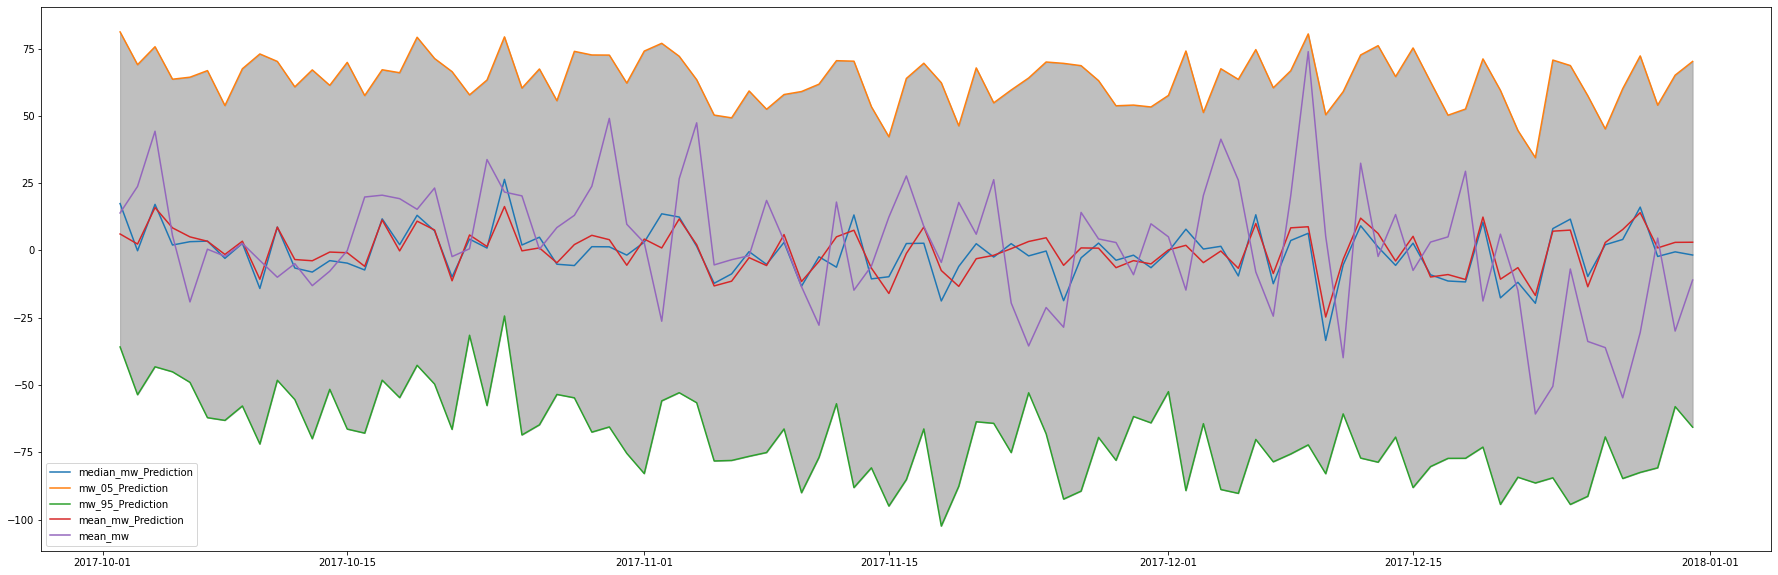

In [ ]:

plt.figure(figsize=(31, 10))

x = df_test['Date']
y1 = df_test['median_mw_Prediction']
y2 =  df_test['mw_05_Prediction']
y3 =  df_test['mw_95_Prediction']
y4 = df_test['mean_mw_Prediction']
y5 = df_test['mean_mw']

plt.plot(x, y1, label = "median_mw_Prediction")
plt.plot(x, y2, label = "mw_05_Prediction")
plt.plot(x, y3, label = "mw_95_Prediction")
plt.plot(x, y4, label = "mean_mw_Prediction")
plt.plot(x, y5, label = "mean_mw")
plt.fill_between(x, y2, y3, color='grey', alpha=0.5)
plt.legend()
plt.show()